In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

import os
import random
import csv
import numpy as np
import glob

import time
from sklearn.metrics import accuracy_score, f1_score

## Load Model

In [2]:
def search_in_labels(filename, label_dict):
    base_name = os.path.splitext(filename)[0]
    
    if "_logmel" in base_name:
        base_name = base_name.replace("_logmel", "")
    if "_flipped" in base_name:
        base_name = base_name.replace("_flipped", "")
    
    parts = base_name.split("_")
    if len(parts) >= 2:
        audio_filename = f"{parts[0]}_{parts[1]}.wav"
    else:
        audio_filename = f"{base_name}.wav"
    
    return label_dict.get(audio_filename, None)

In [5]:
class SpectrogramDataset(Dataset):
        def __init__(self, image_paths, label_dict, transform=None):
            self.image_paths = image_paths
            self.label_dict = label_dict
            
            self.transform = transforms.Compose([
                transforms.Resize((128, 42)),
                transforms.ToTensor()
            ])
        
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            filename = os.path.basename(image_path)
            label = search_in_labels(filename, self.label_dict)
            label_num = 1 if label == "C" else 0
            
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
            
            return image, label_num

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)

class SupervisedContrastiveCNN(nn.Module):

    def __init__(self, input_channels=3, projection_dim=128, feature_dim=512):
        super(SupervisedContrastiveCNN, self).__init__()
        
        self.feature_extractor = self._build_feature_extractor(input_channels)
        
        self.feature_dim = self._get_feature_dim(input_channels)
        
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, projection_dim),
            L2Norm(dim=1) 
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
        
    def _build_feature_extractor(self, input_channels):
        return nn.Sequential(
            # 1st Conv Block
            nn.Conv2d(input_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            
            # 2nd Conv Block
            nn.Conv2d(128, 256, kernel_size=4, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 3rd Conv Block
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Global Average Pooling
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
    
    def _get_feature_dim(self, input_channels):
        with torch.no_grad():
            x = torch.randn(1, input_channels, 128, 42)
            features = self.feature_extractor(x)
            return features.shape[1]
    
    def forward(self, x, return_features=False):

        features = self.feature_extractor(x)
        
        logits = self.classifier(features)
        
        if return_features:
            projections = self.projection_head(features)
            return logits.squeeze(), projections, features
        else:
            return logits.squeeze()



class SupervisedContrastiveLoss(nn.Module):

    def __init__(self, temperature=0.1, minority_weight=2.0):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.minority_weight = minority_weight
        
    def forward(self, projections, labels):
  
        device = projections.device
        batch_size = projections.shape[0]
        
        similarity_matrix = torch.matmul(projections, projections.T) / self.temperature
        
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        mask = mask - torch.eye(batch_size).to(device)
        
        exp_sim = torch.exp(similarity_matrix)
        
        pos_sim = exp_sim * mask
        
        neg_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        all_sim = exp_sim * neg_mask
        
        losses = []
        for i in range(batch_size):
            if mask[i].sum() > 0: 
                pos_sum = pos_sim[i].sum()
                neg_sum = all_sim[i].sum()
                
                if neg_sum > 0:
                    loss_i = -torch.log(pos_sum / neg_sum)
                    
                    if labels[i] == 1:  
                        loss_i = loss_i * self.minority_weight
                    
                    losses.append(loss_i)
        
        if len(losses) > 0:
            return torch.stack(losses).mean()
        else:
            return torch.tensor(0.0).to(device)

class CombinedLoss(nn.Module):
    def __init__(self, classification_loss, contrastive_loss, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.classification_loss = classification_loss
        self.contrastive_loss = contrastive_loss
        self.alpha = alpha  
        
    def forward(self, logits, projections, labels):
        cls_loss = self.classification_loss(logits, labels.float())
        
        cont_loss = self.contrastive_loss(projections, labels)
        
        total_loss = (1 - self.alpha) * cls_loss + self.alpha * cont_loss
        
        return total_loss, cls_loss, cont_loss

    
class ContrastiveSpectrogramDataset(Dataset):
    def __init__(self, image_paths, label_dict, is_training=False, num_views=2):
        self.image_paths = image_paths
        self.label_dict = label_dict
        self.is_training = is_training
        self.num_views = num_views
        
        self.base_transform = transforms.Compose([
            transforms.Resize((128, 42)),
            transforms.ToTensor()
        ])
        
        self.strong_transform = transforms.Compose([
            transforms.Resize((128, 42)),
            transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.1))
        ])
        
        self.cold_transform = transforms.Compose([
            transforms.Resize((128, 42)),
            transforms.RandomAffine(degrees=0, translate=(0.3, 0)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.08))
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path)
        label = search_in_labels(filename, self.label_dict)
        label_num = 1 if label == "C" else 0
        
        image = Image.open(image_path).convert("RGB")
        
        if self.is_training:
            views = []
            
            views.append(self.base_transform(image))
            
            for _ in range(self.num_views - 1):
                if label == "C":  
                    augmented = self.cold_transform(image)
                else:
                    augmented = self.strong_transform(image)
                views.append(augmented)
            
            return views, label_num
        else:
            return self.base_transform(image), label_num
        

In [3]:
label_dict = {}
with open("ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]

Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3181960.47it/s]


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load weights from the pretrained model
model = SupervisedContrastiveCNN().to(device)
retrained_model_path = "best_contrastive_model_sampling.pth"
model.load_state_dict(torch.load(retrained_model_path))
model

SupervisedContrastiveCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (projection_head): Sequential(
    (0): L

In [21]:
model.eval()

# Create a dataset and dataloader for evaluation
data_split = ["train_files", "devel_files"]
img_dir = "spectrogram_images/log_mel"

def collect_image_paths(split_name):
        sub_dir = os.path.join(img_dir, split_name)
        print(f"🔍 Looking for images in: {sub_dir}")
        
        if not os.path.exists(sub_dir):
            print(f"❌ Directory does not exist: {sub_dir}")
            return []
        
        png_files = glob.glob(os.path.join(sub_dir, "*.png"))
        print(f"📁 Found {len(png_files)} PNG files in {split_name}")
        
        return png_files
    

print("🚀 Collecting image paths...")
train_image_paths = collect_image_paths("train_files")
devel_image_paths = collect_image_paths("devel_files")

devel_dataset = SpectrogramDataset(devel_image_paths, label_dict)
devel_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

🚀 Collecting image paths...
🔍 Looking for images in: spectrogram_images/log_mel\train_files
📁 Found 10475 PNG files in train_files
🔍 Looking for images in: spectrogram_images/log_mel\devel_files
📁 Found 10607 PNG files in devel_files


In [22]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

probs = []   
labels = []

model.eval()
with torch.no_grad():
    for X, y in devel_loader:
        logits = model(X.to(device)).squeeze()
        p = torch.sigmoid(logits).cpu().numpy()
        probs.extend(p)
        labels.extend(y.numpy())

probs = np.array(probs)
labels = np.array(labels)

best_t, best_uar = 0.5, 0
best_f1 = 0

print("🎯 Threshold optimization using UAR:")
print("-" * 50)

for t in np.linspace(0.1, 0.9, 81):
    preds = (probs > t).astype(int)
    
    uar = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds)
    
    if uar > best_uar:
        best_uar = uar
        best_t = t
        best_f1 = f1

print(f"🏆 Best Threshold = {best_t:.2f}")
print(f"📊 UAR = {best_uar:.3f}")

🎯 Threshold optimization using UAR:
--------------------------------------------------
🏆 Best Threshold = 0.33
📊 UAR = 0.749


In [23]:
test_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

test_preds = []
test_labels = []

threshold = best_t

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))


Testing: 100%|██████████████████████████████████████████| 10607/10607 [00:56<00:00, 188.47samples/s]


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score

uar = recall_score(test_labels, test_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   F1 Score: {f1:.4f}")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(test_labels)) > 1 and len(set(test_preds)) > 1:
    cm = confusion_matrix(test_labels, test_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")
    
    manual_uar = np.mean(class_recalls)
    print(f"\n✅ UAR Verification:")
    print(f"   sklearn UAR: {uar:.4f}")
    print(f"   Manual UAR:  {manual_uar:.4f}")
    print(f"   Match: {'✓' if abs(uar - manual_uar) < 0.0001 else '✗'}")


📈 PERFORMANCE METRICS:
   F1 Score: 0.2537
   UAR (Unweighted Average Recall): 0.7487

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.8856
   Class 1 (Cold): 0.6118

✅ UAR Verification:
   sklearn UAR: 0.7487
   Manual UAR:  0.7487
   Match: ✓


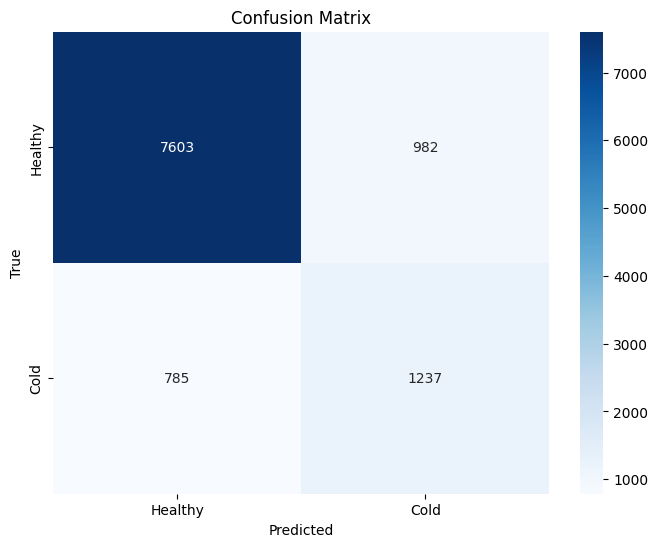

In [25]:
# visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names=['Healthy', 'Cold'])

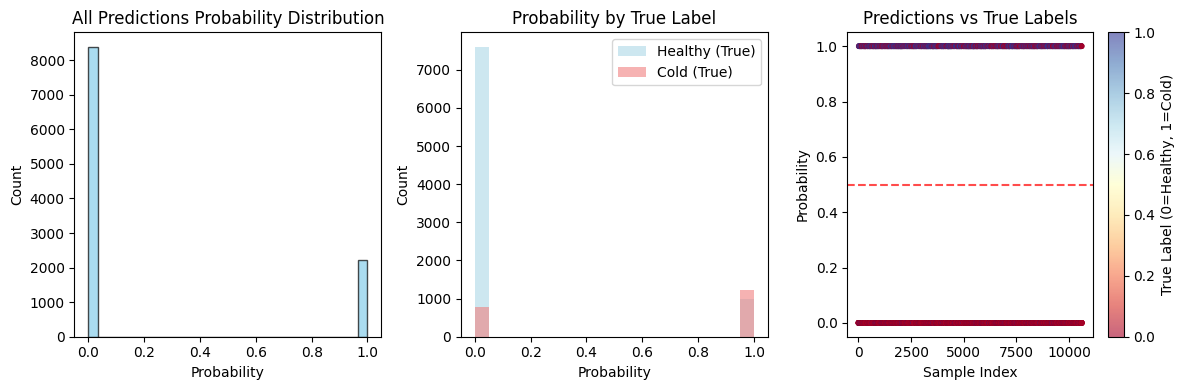

概率分布统计:
平均概率:       0.2092
概率标准差:     0.4067
最小概率:       0.0000
最大概率:       1.0000

Healthy 样本平均概率: 0.1144
Cold 样本平均概率:    0.6118


In [26]:

val_probs = np.array(test_preds)
val_labels = np.array(test_labels)

plt.figure(figsize=(12, 4))

# 第一张图：所有样本的概率直方图
plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

# 第二张图：按真标签分类的概率分布
healthy_probs = val_probs[val_labels == 0]
cold_probs    = val_probs[val_labels == 1]

plt.subplot(1, 3, 2)
plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs,    bins=20, alpha=0.6, label='Cold (True)',    color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

# 第三张图：每个样本的概率散点图，并在 y=0.5 处画一条阈值线
plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
            cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label (0=Healthy, 1=Cold)')

plt.tight_layout()
plt.show()

# 接下来输出一些统计信息
print("=" * 40)
print("概率分布统计:")
print("=" * 40)
print(f"平均概率:       {val_probs.mean():.4f}")
print(f"概率标准差:     {val_probs.std():.4f}")
print(f"最小概率:       {val_probs.min():.4f}")
print(f"最大概率:       {val_probs.max():.4f}")
print()
print(f"Healthy 样本平均概率: {healthy_probs.mean():.4f}")
print(f"Cold 样本平均概率:    {cold_probs.mean():.4f}")
